In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# keras
import keras
from keras.models import load_model, Model
from scipy.ndimage import convolve
# data processing pipeline
from data_processing import processing_pipeline

In [23]:
# load model
model = load_model('./models/LeNet-5-mod-155214393981338.h5')

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 54, 54, 2)         100       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 32)        608       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               5120128   
__________

In [45]:
# getting X and y
f1 = './data/sample_data/Farah_Pot_5cm_sq_15um.txt'
#f2 = './data/sample_data/Grant_Pot_5cm_sq_15um.txt'
files = [f1]

patch_size = 60
X, y = processing_pipeline(files, patch_size)
print(f"There are {len(y)} patches of shapes {X.shape[1:]}.")

There are 2795 patches of shapes (60, 60).


In [46]:
X = X.reshape(*X.shape,1)

In [47]:
def get_filter(layer,index):
    return model.get_weights()[layer][:,:,0,index]

def apply_filter(X, sample, weights):
    return convolve(X[sample,:,:,0], weights)

def viz_filtered_sample(X, sample, weights, ax=None):
    colv_samp = convolve(X[sample,:,:,0], weights)
    return sns.heatmap(colv_samp, cmap=cmap, cbar = False, ax=ax,
                      xticklabels=False,
                      yticklabels=False)

In [48]:
X.shape

(2795, 60, 60, 1)

Text(0.5, 1.0, 'After Filter 2')

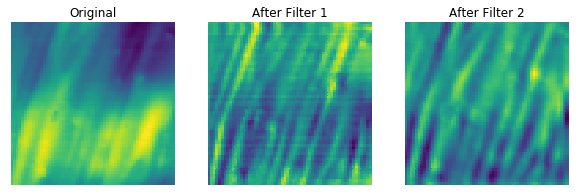

In [186]:
# colormap and sample
cmap='viridis'
# sample_idx = np.random.randint(0,len(X),1)[0]
sample_idx = 10

fig, axes = plt.subplots(1,3,figsize = (10,3))

viz_filtered_sample(X, sample_idx, np.identity(1), axes[0])
axes[0].set_title('Original')

weigths = get_filter(0,0)
viz_filtered_sample(X, sample_idx, weigths, axes[1])
axes[1].set_title('After Filter 1')

weigths = get_filter(0,1)
viz_filtered_sample(X, sample_idx, weigths, axes[2])
axes[2].set_title('After Filter 2')

# timestamp = str(int(time.time()*1000000))[0:-1]
# plt.savefig('./figures/{0}_by_{0}_input_{1}_by_{1}_filter_{2}.png'.format(patch_size, 7, timestamp),
#            bbox_inches='tight', dpi=200)

## Visualizing layer outputs 

In [ ]:
# modified from https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras

In [187]:
sample = X[10]

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(sample.reshape(1,*sample.shape[:2],1))
 
def display_activation(activations, nrows, ncols, act_index, size=2.5): 
    activation = activations[act_index]
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*size,nrows*size))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(activation[0, :, :, i], cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.subplots_adjust(hspace=0.02, wspace=-0.1)

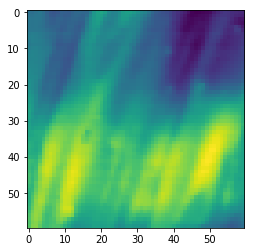

In [188]:
plt.imshow(sample[:,:,0])

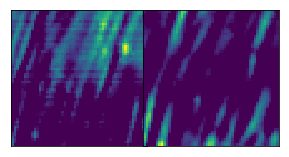

In [189]:
display_activation(activations,1, 2, 0)

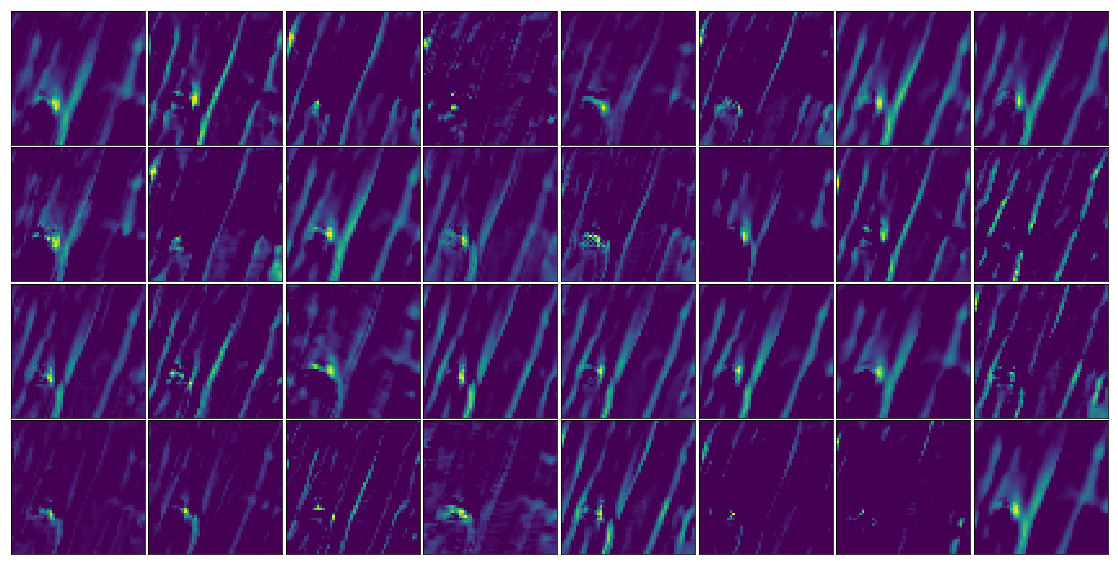

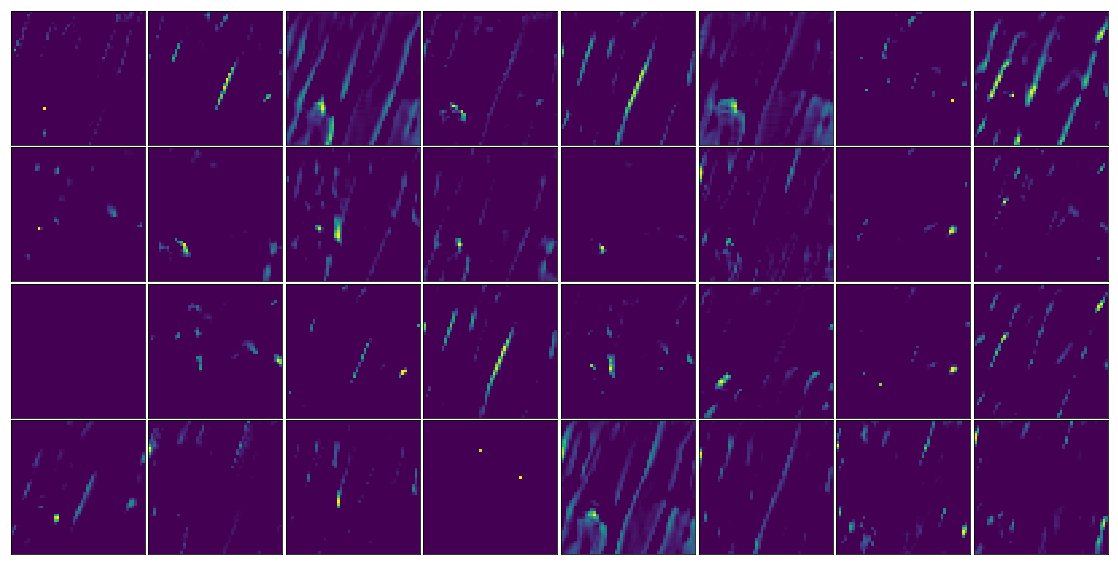

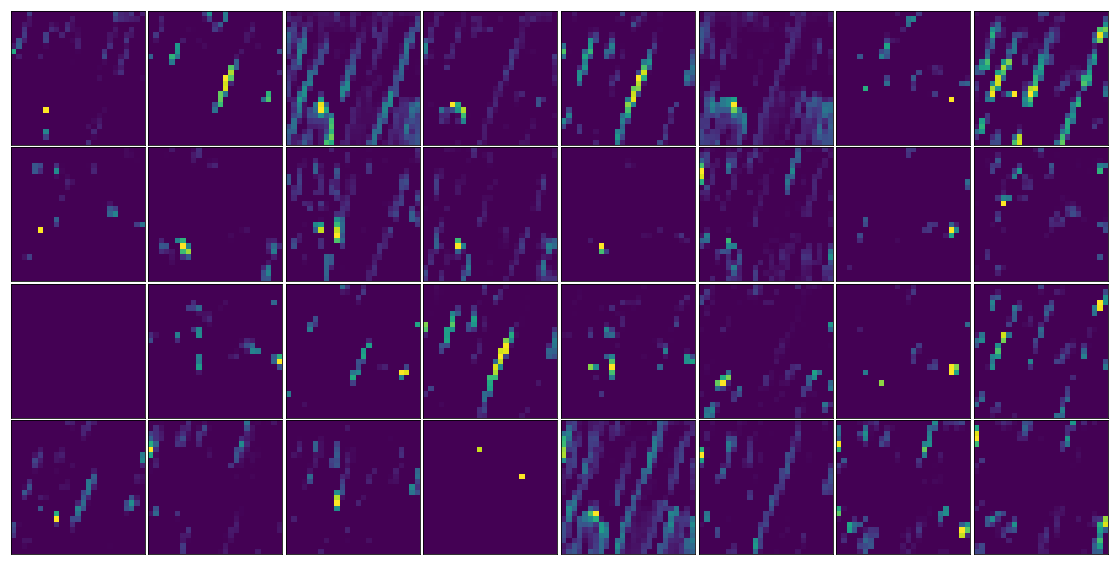

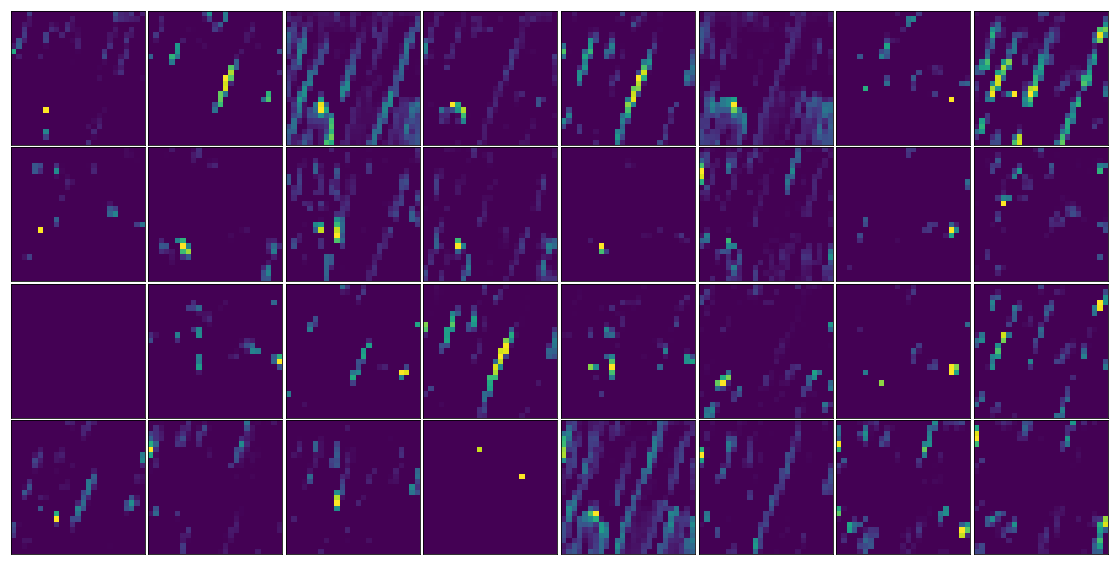

In [183]:
for i in range(1,5):
    display_activation(activations,4,8,i)